# Render a Nerfie video!

**Author**: [Keunhong Park](https://keunhong.com)

[[Project Page](https://nerfies.github.io)]
[[Paper](https://storage.googleapis.com/nerfies-public/videos/nerfies_paper.pdf)]
[[Video](https://www.youtube.com/watch?v=MrKrnHhk8IA)]
[[GitHub](https://github.com/google/nerfies)]

This notebook renders a figure-8 orbit video using the test cameras generated in the capture processing notebook.

You can also load your own custom cameras by modifying the code slightly.

### Instructions

1. Convert a video into our dataset format using the [capture processing notebook](https://colab.sandbox.google.com/github/google/nerfies/blob/main/notebooks/Nerfies_Capture_Processing.ipynb).
2. Train a Nerfie model using the [training notebook](https://colab.sandbox.google.com/github/google/nerfies/blob/main/notebooks/Nerfies_Training.ipynb)
3. Run this notebook!


### Notes
 * Please report issues on the [GitHub issue tracker](https://github.com/google/nerfies/issues).

## Environment Setup

In [1]:
!pip install flax immutabledict mediapy
!pip install git+https://github.com/google/nerfies@v2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/google/nerfies (to revision v2) to /tmp/pip-req-build-jh9vpsgl
  Running command git clone --filter=blob:none --quiet https://github.com/google/nerfies /tmp/pip-req-build-jh9vpsgl
  Running command git checkout -b v2 --track origin/v2
  Switched to a new branch 'v2'
  Branch 'v2' set up to track remote branch 'v2' from 'origin'.
  Resolved https://github.com/google/nerfies to commit 04623e4474bde3459e2f7f2b5c9174d9e0faa7b1
  Preparing metadata (setup.py) ... done
  Created wheel for nerfies: filename=nerfies-0.0.2-py3-none-any.whl size=67944 sha256=e37991665cbf75f5a6072ec38231792a77d6f9b50c9749db8fe84139b15f85e1
  Stored in directory: /tmp/pip-ephem-wheel-cache-v0vopzkr/wheels/f5/ca/c8

In [ ]:
pip install flax==0.5.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install jax==0.4.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install jaxlib==0.4.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import jax

In [ ]:
# @title Configure notebook runtime
# @markdown If you would like to use a GPU runtime instead, change the runtime type by going to `Runtime > Change runtime type`. 
# @markdown You will have to use a smaller batch size on GPU.

runtime_type = 'gpu'  # @param ['gpu', 'tpu']
if runtime_type == 'tpu':
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()

print('Detected Devices:', jax.devices())

Detected Devices: [CpuDevice(id=0)]


In [1]:
# @title Mount Google Drive
# @markdown Mount Google Drive onto `/content/gdrive`. You can skip this if running locally.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!python --version

Python 3.9.16


In [ ]:
# @title Define imports and utility functions.

import jax
from jax.config import config as jax_config
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

import flax
import flax.linen as nn
from flax import jax_utils
from flax import optim
from flax.metrics import tensorboard
from flax.training import checkpoints

from absl import logging
from io import BytesIO
import random as pyrandom
import numpy as np
import PIL
import IPython
import tempfile
import imageio
import mediapy
from IPython.display import display, HTML
from base64 import b64encode


# Monkey patch logging.
def myprint(msg, *args, **kwargs):
 print(msg % args)

logging.info = myprint 
logging.warn = myprint
logging.error = myprint

/usr/local/lib/python3.9/dist-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/usr/local/lib/python3.9/dist-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [ ]:
!pip show flax

Name: flax
Version: 0.5.3
Summary: Flax: A neural network library for JAX designed for flexibility
Home-page: https://github.com/google/flax
Author: Flax team
Author-email: flax-dev@google.com
License: UNKNOWN
Location: /usr/local/lib/python3.9/dist-packages
Requires: jax, matplotlib, msgpack, numpy, optax, PyYAML, rich, tensorstore, typing-extensions
Required-by: dopamine-rl


In [ ]:
for i in range(1, 3):
  print(i)

1
2


In [ ]:
# @title Model and dataset configuration
# @markdown Change the directories to where you saved your capture and experiment.


from pathlib import Path
from pprint import pprint
import gin
from IPython.display import display, Markdown

from nerfies import configs


# @markdown The working directory where the trained model is.
train_dir = '/content/gdrive/MyDrive/nerfies_1/experiments/capture1/exp1'  # @param {type: "string"}
# @markdown The directory to the dataset capture.
data_dir = '/content/gdrive/MyDrive/nerfies_1/captures/capture1'  # @param {type: "string"}

checkpoint_dir = Path(train_dir, 'checkpoints')
checkpoint_dir.mkdir(exist_ok=True, parents=True)

config_path = Path(train_dir, 'config.gin')
with open(config_path, 'r') as f:
  logging.info('Loading config from %s', config_path)
  config_str = f.read()
gin.parse_config(config_str)

config_path = Path(train_dir, 'config.gin')
with open(config_path, 'w') as f:
  logging.info('Saving config to %s', config_path)
  f.write(config_str)

exp_config = configs.ExperimentConfig()
model_config = configs.ModelConfig()
train_config = configs.TrainConfig()
eval_config = configs.EvalConfig()

display(Markdown(
    gin.config.markdown(gin.operative_config_str())))

Loading config from /content/gdrive/MyDrive/nerfies_1/experiments/capture1/exp1/config.gin
Saving config to /content/gdrive/MyDrive/nerfies_1/experiments/capture1/exp1/config.gin


#### Parameters for EvalConfig:

    EvalConfig.chunk = 8192
    EvalConfig.eval_once = False
    EvalConfig.num_test_eval = 10
    EvalConfig.num_train_eval = 10
    EvalConfig.num_val_eval = 10
    EvalConfig.save_output = True
    
#### Parameters for ExperimentConfig:

    ExperimentConfig.datasource_spec = \
        {'camera_type': 'json',
         'data_dir': '/content/gdrive/MyDrive/nerfies_1/captures/capture1',
         'type': 'nerfies'}
    ExperimentConfig.datasource_type = 'nerfies'
    ExperimentConfig.image_scale = 8
    ExperimentConfig.random_seed = 12345
    ExperimentConfig.subname = None
    
#### Parameters for ModelConfig:

    ModelConfig.alpha_channels = 1
    ModelConfig.appearance_metadata_dims = 8
    ModelConfig.camera_metadata_dims = 2
    ModelConfig.nerf_rgb_branch_depth = 1
    ModelConfig.nerf_rgb_branch_width = 128
    ModelConfig.nerf_skips = (4,)
    ModelConfig.nerf_trunk_depth = 8
    ModelConfig.nerf_trunk_width = 256
    ModelConfig.noise_std = None
    ModelConfig.num_coarse_samples = 64
    ModelConfig.num_fine_samples = 64
    ModelConfig.num_nerf_point_freqs = 10
    ModelConfig.num_nerf_viewdir_freqs = 4
    ModelConfig.num_warp_features = 8
    ModelConfig.num_warp_freqs = 8
    ModelConfig.rgb_channels = 3
    ModelConfig.use_alpha_condition = False
    ModelConfig.use_appearance_metadata = 1
    ModelConfig.use_camera_metadata = False
    ModelConfig.use_linear_disparity = False
    ModelConfig.use_rgb_condition = False
    ModelConfig.use_sample_at_infinity = True
    ModelConfig.use_stratified_sampling = True
    ModelConfig.use_trunk_condition = False
    ModelConfig.use_viewdirs = 1
    ModelConfig.use_warp = True
    ModelConfig.use_white_background = False
    ModelConfig.warp_field_type = 'se3'
    ModelConfig.warp_metadata_encoder_type = 'glo'
    
#### Parameters for TrainConfig:

    TrainConfig.background_loss_weight = 0.0
    TrainConfig.background_points_batch_size = 16384
    TrainConfig.batch_size = 32
    TrainConfig.elastic_loss_type = 'log_svals'
    TrainConfig.elastic_loss_weight_schedule = ('constant', 0.0)
    TrainConfig.elastic_reduce_method = 'weight'
    TrainConfig.histogram_every = 5000
    TrainConfig.log_every = 500
    TrainConfig.max_steps = 100000
    TrainConfig.print_every = 100
    TrainConfig.save_every = 10000
    TrainConfig.shuffle_buffer_size = 5000000
    TrainConfig.time_alpha_schedule = ('constant', 0.0)
    TrainConfig.use_background_loss = False
    TrainConfig.use_elastic_loss = False
    TrainConfig.use_warp_reg_loss = False
    TrainConfig.warp_alpha_schedule = \
        {'final_value': 8,
         'initial_value': 0.0,
         'num_steps': 80000,
         'type': 'linear'}
    TrainConfig.warp_reg_loss_alpha = -2.0
    TrainConfig.warp_reg_loss_scale = 0.001
    TrainConfig.warp_reg_loss_weight = 0.0

*** Loading dataset IDs from /content/gdrive/MyDrive/nerfies_1/captures/capture1/dataset.json
Creating datasource of type NerfiesDataSource with use_appearance_id=1, use_camera_id=False, use_warp_id=True, use_depth=False, use_time=False


""

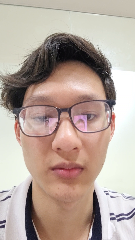

In [ ]:
# @title Create datasource and show an example.

from nerfies import datasets
from nerfies import image_utils

datasource = datasets.from_config(
  exp_config.datasource_spec,
  image_scale=exp_config.image_scale,
  use_appearance_id=model_config.use_appearance_metadata,
  use_camera_id=model_config.use_camera_metadata,
  use_warp_id=model_config.use_warp,
  random_seed=exp_config.random_seed)

mediapy.show_image(datasource.load_rgb(datasource.train_ids[0]))

In [ ]:
# @title Initialize model
# @markdown Defines the model and initializes its parameters.

from flax.training import checkpoints
from nerfies import models
from nerfies import model_utils
from nerfies import schedules
from nerfies import training


rng = random.PRNGKey(exp_config.random_seed)
np.random.seed(exp_config.random_seed + jax.process_index())
devices = jax.devices()

learning_rate_sched = schedules.from_config(train_config.lr_schedule)
warp_alpha_sched = schedules.from_config(train_config.warp_alpha_schedule)
elastic_loss_weight_sched = schedules.from_config(
    train_config.elastic_loss_weight_schedule)

rng, key = random.split(rng)
params = {}
model, params['model'] = models.construct_nerf(
    key,
    model_config,
    batch_size=train_config.batch_size,
    appearance_ids=datasource.appearance_ids,
    camera_ids=datasource.camera_ids,
    warp_ids=datasource.warp_ids,
    near=datasource.near,
    far=datasource.far,
    use_warp_jacobian=train_config.use_elastic_loss,
    use_weights=train_config.use_elastic_loss)

optimizer_def = optim.Adam(learning_rate_sched(0))
optimizer = optimizer_def.create(params)
state = model_utils.TrainState(
    optimizer=optimizer,
    warp_alpha=warp_alpha_sched(0))
scalar_params = training.ScalarParams(
    learning_rate=learning_rate_sched(0),
    elastic_loss_weight=elastic_loss_weight_sched(0),
    background_loss_weight=train_config.background_loss_weight)
logging.info('Restoring checkpoint from %s', checkpoint_dir)
state = checkpoints.restore_checkpoint(checkpoint_dir, state)
step = state.optimizer.state.step + 1
state = jax_utils.replicate(state, devices=devices)
del params

/usr/local/lib/python3.9/dist-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/usr/local/lib/python3.9/dist-packages/flax/core/lift.py:112: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  scopes, treedef = jax.tree_flatten(scope_tree)
/usr/local/lib/python3.9/dist-packages/flax/core/lift.py:585: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  leaves = jax.tree_leaves(x)
/usr/local/lib/python3.9/dist-packages/flax/core/lift.py:594: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  axis_sizes = set(jax.tree_leaves(axis_sizes))
/usr/local/lib/python3.9/dist-packages/fl

Restoring checkpoint from /content/gdrive/MyDrive/nerfies_1/experiments/capture1/exp1/checkpoints
Restoring checkpoint from /content/gdrive/MyDrive/nerfies_1/experiments/capture1/exp1/checkpoints/checkpoint_100000


In [ ]:
# @title Define pmapped render function.

import functools
from nerfies import evaluation

devices = jax.devices()


def _model_fn(key_0, key_1, params, rays_dict, warp_extra):
  out = model.apply({'params': params},
                    rays_dict,
                    warp_extra=warp_extra,
                    rngs={
                        'coarse': key_0,
                        'fine': key_1
                    },
                    mutable=False)
  return jax.lax.all_gather(out, axis_name='batch')

pmodel_fn = jax.pmap(
    # Note rng_keys are useless in eval mode since there's no randomness.
    _model_fn,
    in_axes=(0, 0, 0, 0, 0),  # Only distribute the data input.
    devices=devices,
    donate_argnums=(3,),  # Donate the 'rays' argument.
    axis_name='batch',
)

render_fn = functools.partial(evaluation.render_image,
                              model_fn=pmodel_fn,
                              device_count=len(devices),
                              chunk=eval_config.chunk)

In [ ]:
# @title Load cameras.

from nerfies import utils

camera_path = 'camera-paths/orbit-mild'  # @param {type: 'string'}

camera_dir = Path(data_dir, camera_path)
print(f'Loading cameras from {camera_dir}')
test_camera_paths = datasource.glob_cameras(camera_dir)
test_cameras = utils.parallel_map(datasource.load_camera, test_camera_paths, show_pbar=True)

Loading cameras from /content/gdrive/MyDrive/nerfies_1/captures/capture1/camera-paths/orbit-mild


100%|██████████| 100/100 [00:00<00:00, 837.09it/s]


/usr/local/lib/python3.9/dist-packages/jax/_src/xla_bridge.py:600: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  warnings.warn(


Rendering frame 1/100


/usr/local/lib/python3.9/dist-packages/jax/_src/interpreters/mlir.py:711: UserWarning: Some donated buffers were not usable: ShapedArray(float32[8192,3]), ShapedArray(uint32[8192,1]), ShapedArray(uint32[8192,1]), ShapedArray(float32[8192,3]), ShapedArray(float32[8192,2]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn(f"Some donated buffers were not usable: {', '.join(unused_donations)}.\n{msg}")
/usr/local/lib/python3.9/dist-packages/jax/_src/interpreters/mlir.py:711: UserWarning: Some donated buffers were not usable: ShapedArray(float32[7824,3]), ShapedArray(uint32[7824,1]), ShapedArray(uint32[7824,1]), ShapedArray(float32[7824,3]), ShapedArray(float32[7824,2]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn(f"Some donated buffers were not usable: {', '.join(unused_donations)}.\n{msg}")


Rendering took 193.


,

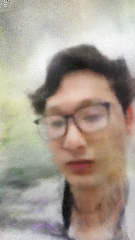
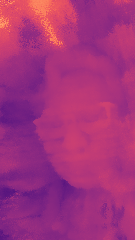

Rendering frame 2/100
Rendering took 176.


,

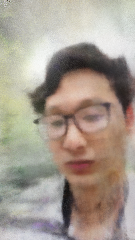
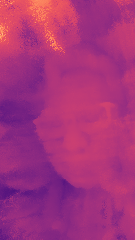

Rendering frame 3/100
Rendering took 174.


,

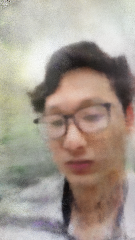
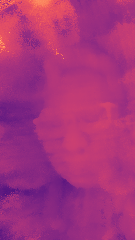

Rendering frame 4/100


KeyboardInterrupt: ignored

In [ ]:
# @title Render video frames.
from nerfies import visualization as viz


rng = rng + jax.host_id()  # Make random seed separate across hosts.
keys = random.split(rng, len(devices))

results = []
for i in range(len(test_cameras)):
  print(f'Rendering frame {i+1}/{len(test_cameras)}')
  camera = test_cameras[i]
  batch = datasets.camera_to_rays(camera)
  batch['metadata'] = {
      'appearance': jnp.zeros_like(batch['origins'][..., 0, jnp.newaxis], jnp.uint32),
      'warp': jnp.zeros_like(batch['origins'][..., 0, jnp.newaxis], jnp.uint32),
  }

  render = render_fn(state, batch, rng=rng)
  rgb = np.array(render['rgb'])
  depth_med = np.array(render['med_depth'])
  results.append((rgb, depth_med))
  depth_viz = viz.colorize(depth_med.squeeze(), cmin=datasource.near, cmax=datasource.far, invert=True)
  mediapy.show_images([rgb, depth_viz])

In [ ]:
# @title Show rendered video.

fps = 30  # @param {type:'number'}

frames = []
for rgb, depth in results:
  depth_viz = viz.colorize(depth.squeeze(), cmin=datasource.near, cmax=datasource.far, invert=True)
  frame = np.concatenate([rgb, depth_viz], axis=1)
  frames.append(image_utils.image_to_uint8(frame))

mediapy.show_video(frames, fps=fps)

In [ ]:
type(frames[1])

numpy.ndarray